# Analysis of FAIR metrics

In this notebook, the retrieved results of the FAIR metrics collection is analyzed.

In [53]:
from datetime import date
import statistics
from collections import Counter
from pathlib import Path
import os

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import table 
import matplotlib.pyplot as plt
import matplotlib.table as table
import seaborn as sns
from scipy import stats

In [54]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

Folders and constants

In [55]:
subset = "group"  # "user", "group", "all"

# todo make this into something nice
how_fair_is = pd.read_csv("output/repositories_howfairis_2021-11-24.csv")
languages = pd.read_csv("output/languages_2021-11-24.csv")
contributors = pd.read_csv("output/contributors_2021-11-24.csv")
topics = pd.read_csv("output/topics_2021-11-24.csv")

# file paths
fp_repos = Path("..", "collect_repositories", "results", "repositories_filtered_2021-11-24.csv")
fp_figs = Path("figs")

# create output folder if not exists
fp_figs.mkdir(exist_ok=True)

## Load filtered repositories
Load (manually) filtered repositories into notebook.

In [56]:
repos = pd.read_csv(fp_repos)

## Filtering for research groups or private users only

In [57]:
users = pd.read_excel("../collect_users/results/users_enriched_updated_2021-11-20.xlsx")

In [58]:
def add_research_group_filter(dataset):
    user_is_research_group = []
    for row in dataset.iterrows():
        try:
            owner = row[1]['owner']
        except:
            owner = row[1]['html_url_repository'].split('/')[-2]
            
            
      
        row_users = users.loc[users['user_id'] == owner]
        if len(row_users['is_research_group']) == 0:
            user_is_research_group.append(False)
        for i in row_users['is_research_group']:
            if i == 1:
                user_is_research_group.append(True)
                break
            else:
                user_is_research_group.append(False)
                break
                    
    return user_is_research_group
    

In [59]:
repos['is_research_group'] = add_research_group_filter(repos)
contributors['is_research_group'] = add_research_group_filter(contributors)
topics['is_research_group'] = add_research_group_filter(topics)
languages['is_research_group'] = add_research_group_filter(languages)
how_fair_is['is_research_group'] = add_research_group_filter(how_fair_is)

## Subset repositories
Make a subset of repositories on "user", "group", or "all".

- "user" - Account of individual researcher
- "group" - Account of research group
- "all" - Both individual researcher or research group

In [60]:
if subset == "user":
    repos = repos[~repos['is_research_group']]
    contributors = contributors[~contributors['is_research_group']]
    topics = topics[~topics['is_research_group']]
    languages = languages[~languages['is_research_group']]
    how_fair_is = how_fair_is[~how_fair_is['is_research_group']]
elif subset == "group":
    repos = repos[repos['is_research_group']]
    contributors = contributors[contributors['is_research_group']]
    topics = topics[topics['is_research_group']]
    languages = languages[languages['is_research_group']]
    how_fair_is = how_fair_is[how_fair_is['is_research_group']]

## Datasets

Using the github API and the Howfairis software, we collected data on the repositories, their FAIRness, the languages used in the repository, the amount of contributors for each repository and the topics mentoined in each repository. 

The Howfairis software gives  boolean value on five measures of FAIRness for each repository. These five measures consist of having a repository (which is always True for our dataset), having a license, being available in a registry, allowing citation of the software and following the FAIR software quality checklist. Below, the first five rows of the datasets are displayed. 

In [61]:
repos

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,allow_forking,is_template,topics,visibility,forks,open_issues,watchers,default_branch,permissions,is_research_group
53,157202219,MDEwOlJlcG9zaXRvcnkxNTcyMDIyMTk=,callmice,amices/callmice,False,amices,https://github.com/amices/callmice,Test and demonstrates how to use mice in your ...,False,https://api.github.com/repos/amices/callmice,...,True,False,[],public,0,0,0,master,NaN,True
54,159842075,MDEwOlJlcG9zaXRvcnkxNTk4NDIwNzU=,dsMice,amices/dsMice,False,amices,https://github.com/amices/dsMice,Multivariate Imputation by Chained Equations f...,False,https://api.github.com/repos/amices/dsMice,...,True,False,"['chained-equations', 'datashield', 'imputatio...",public,1,0,2,master,NaN,True
55,159489076,MDEwOlJlcG9zaXRvcnkxNTk0ODkwNzY=,dsMiceClient,amices/dsMiceClient,False,amices,https://github.com/amices/dsMiceClient,Multivariate Imputation by Chained Equations f...,False,https://api.github.com/repos/amices/dsMiceClient,...,True,False,"['chained-equations', 'datashield', 'imputatio...",public,1,1,0,master,NaN,True
56,8910139,MDEwOlJlcG9zaXRvcnk4OTEwMTM5,mice,amices/mice,False,amices,https://github.com/amices/mice,Multivariate Imputation by Chained Equations,False,https://api.github.com/repos/amices/mice,...,True,False,"['chained-equations', 'fcs', 'imputation', 'mi...",public,79,21,262,master,NaN,True
57,187627582,MDEwOlJlcG9zaXRvcnkxODc2Mjc1ODI=,mice3paper,amices/mice3paper,False,amices,https://github.com/amices/mice3paper,Materials documenting some facilities in mice 3,False,https://api.github.com/repos/amices/mice3paper,...,True,False,[],public,0,0,0,master,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,337555188,MDEwOlJlcG9zaXRvcnkzMzc1NTUxODg=,osmenrich,sodascience/osmenrich,False,sodascience,https://github.com/sodascience/osmenrich,Enrich sf data with geographic features from O...,False,https://api.github.com/repos/sodascience/osmen...,...,True,False,"['geospatial', 'geospatial-data', 'odissei', '...",public,2,3,8,main,NaN,True
1183,338014671,MDEwOlJlcG9zaXRvcnkzMzgwMTQ2NzE=,osmenrich_docker,sodascience/osmenrich_docker,False,sodascience,https://github.com/sodascience/osmenrich_docker,Setup local OSRM and Overpass API endpoints us...,False,https://api.github.com/repos/sodascience/osmen...,...,True,False,"['docker', 'osrm', 'overpass-api', 'soda-scien...",public,0,0,3,master,NaN,True
1184,333718109,MDEwOlJlcG9zaXRvcnkzMzM3MTgxMDk=,presentation-osmenrich-sig,sodascience/presentation-osmenrich-sig,False,sodascience,https://github.com/sodascience/presentation-os...,Presentation for the UU special interest group...,False,https://api.github.com/repos/sodascience/prese...,...,True,False,"['data-science', 'geospatial', 'software']",public,0,1,1,main,NaN,True
1535,199618365,MDEwOlJlcG9zaXRvcnkxOTk2MTgzNjU=,development-API,vitality-data-center/development-API,False,vitality-data-center,https://github.com/vitality-data-center/develo...,NaN,False,https://api.github.com/repos/vitality-data-cen...,...,True,False,[],public,1,0,1,master,NaN,True


In [62]:
how_fair_is

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,open_issues,watchers,default_branch,permissions,howfairis_repository,howfairis_license,howfairis_registry,howfairis_citation,howfairis_checklist,is_research_group
53,157202219,MDEwOlJlcG9zaXRvcnkxNTcyMDIyMTk=,callmice,amices/callmice,False,amices,https://github.com/amices/callmice,Test and demonstrates how to use mice in your ...,False,https://api.github.com/repos/amices/callmice,...,0,0,master,NaN,True,False,False,False,False,True
54,159842075,MDEwOlJlcG9zaXRvcnkxNTk4NDIwNzU=,dsMice,amices/dsMice,False,amices,https://github.com/amices/dsMice,Multivariate Imputation by Chained Equations f...,False,https://api.github.com/repos/amices/dsMice,...,0,2,master,NaN,True,False,False,False,False,True
55,159489076,MDEwOlJlcG9zaXRvcnkxNTk0ODkwNzY=,dsMiceClient,amices/dsMiceClient,False,amices,https://github.com/amices/dsMiceClient,Multivariate Imputation by Chained Equations f...,False,https://api.github.com/repos/amices/dsMiceClient,...,1,0,master,NaN,True,False,False,False,False,True
56,8910139,MDEwOlJlcG9zaXRvcnk4OTEwMTM5,mice,amices/mice,False,amices,https://github.com/amices/mice,Multivariate Imputation by Chained Equations,False,https://api.github.com/repos/amices/mice,...,21,262,master,NaN,True,False,True,False,False,True
57,187627582,MDEwOlJlcG9zaXRvcnkxODc2Mjc1ODI=,mice3paper,amices/mice3paper,False,amices,https://github.com/amices/mice3paper,Materials documenting some facilities in mice 3,False,https://api.github.com/repos/amices/mice3paper,...,0,0,master,NaN,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,337555188,MDEwOlJlcG9zaXRvcnkzMzc1NTUxODg=,osmenrich,sodascience/osmenrich,False,sodascience,https://github.com/sodascience/osmenrich,Enrich sf data with geographic features from O...,False,https://api.github.com/repos/sodascience/osmen...,...,3,8,main,NaN,True,True,False,True,False,True
1183,338014671,MDEwOlJlcG9zaXRvcnkzMzgwMTQ2NzE=,osmenrich_docker,sodascience/osmenrich_docker,False,sodascience,https://github.com/sodascience/osmenrich_docker,Setup local OSRM and Overpass API endpoints us...,False,https://api.github.com/repos/sodascience/osmen...,...,0,3,master,NaN,True,True,False,False,False,True
1184,333718109,MDEwOlJlcG9zaXRvcnkzMzM3MTgxMDk=,presentation-osmenrich-sig,sodascience/presentation-osmenrich-sig,False,sodascience,https://github.com/sodascience/presentation-os...,Presentation for the UU special interest group...,False,https://api.github.com/repos/sodascience/prese...,...,1,1,main,NaN,True,False,False,False,False,True
1535,199618365,MDEwOlJlcG9zaXRvcnkxOTk2MTgzNjU=,development-API,vitality-data-center/development-API,False,vitality-data-center,https://github.com/vitality-data-center/develo...,NaN,False,https://api.github.com/repos/vitality-data-cen...,...,0,1,master,NaN,True,False,False,False,False,True


In [63]:
languages

,html_url_repository,language,num_chars,is_research_group
107,https://github.com/amices/callmice,R,1394,True
108,https://github.com/amices/dsMice,R,64362,True
109,https://github.com/amices/dsMice,TeX,754,True
110,https://github.com/amices/dsMiceClient,R,80811,True
111,https://github.com/amices/dsMiceClient,TeX,754,True
...,...,...,...,...
2207,https://github.com/sodascience/osmenrich_docker,Shell,9214,True
2208,https://github.com/sodascience/osmenrich_docker,Dockerfile,3496,True
2209,https://github.com/sodascience/presentation-os...,R,9168,True
2974,https://github.com/vitality-data-center/enviro...,Python,154167,True


In [64]:
contributors

,html_url_repository,login,id,node_id,avatar_url,gravatar_id,url,html_url,followers_url,following_url,...,starred_url,subscriptions_url,organizations_url,repos_url,events_url,received_events_url,type,site_admin,contributions,is_research_group
166,https://github.com/amices/callmice,stefvanbuuren,3919919,MDQ6VXNlcjM5MTk5MTk=,https://avatars.githubusercontent.com/u/391991...,NaN,https://api.github.com/users/stefvanbuuren,https://github.com/stefvanbuuren,https://api.github.com/users/stefvanbuuren/fol...,https://api.github.com/users/stefvanbuuren/fol...,...,https://api.github.com/users/stefvanbuuren/sta...,https://api.github.com/users/stefvanbuuren/sub...,https://api.github.com/users/stefvanbuuren/orgs,https://api.github.com/users/stefvanbuuren/repos,https://api.github.com/users/stefvanbuuren/eve...,https://api.github.com/users/stefvanbuuren/rec...,User,False,3,True
167,https://github.com/amices/dsMice,stefvanbuuren,3919919,MDQ6VXNlcjM5MTk5MTk=,https://avatars.githubusercontent.com/u/391991...,NaN,https://api.github.com/users/stefvanbuuren,https://github.com/stefvanbuuren,https://api.github.com/users/stefvanbuuren/fol...,https://api.github.com/users/stefvanbuuren/fol...,...,https://api.github.com/users/stefvanbuuren/sta...,https://api.github.com/users/stefvanbuuren/sub...,https://api.github.com/users/stefvanbuuren/orgs,https://api.github.com/users/stefvanbuuren/repos,https://api.github.com/users/stefvanbuuren/eve...,https://api.github.com/users/stefvanbuuren/rec...,User,False,12,True
168,https://github.com/amices/dsMice,paularaissa,4760063,MDQ6VXNlcjQ3NjAwNjM=,https://avatars.githubusercontent.com/u/476006...,NaN,https://api.github.com/users/paularaissa,https://github.com/paularaissa,https://api.github.com/users/paularaissa/follo...,https://api.github.com/users/paularaissa/follo...,...,https://api.github.com/users/paularaissa/starr...,https://api.github.com/users/paularaissa/subsc...,https://api.github.com/users/paularaissa/orgs,https://api.github.com/users/paularaissa/repos,https://api.github.com/users/paularaissa/event...,https://api.github.com/users/paularaissa/recei...,User,False,4,True
169,https://github.com/amices/dsMiceClient,stefvanbuuren,3919919,MDQ6VXNlcjM5MTk5MTk=,https://avatars.githubusercontent.com/u/391991...,NaN,https://api.github.com/users/stefvanbuuren,https://github.com/stefvanbuuren,https://api.github.com/users/stefvanbuuren/fol...,https://api.github.com/users/stefvanbuuren/fol...,...,https://api.github.com/users/stefvanbuuren/sta...,https://api.github.com/users/stefvanbuuren/sub...,https://api.github.com/users/stefvanbuuren/orgs,https://api.github.com/users/stefvanbuuren/repos,https://api.github.com/users/stefvanbuuren/eve...,https://api.github.com/users/stefvanbuuren/rec...,User,False,22,True
170,https://github.com/amices/mice,stefvanbuuren,3919919,MDQ6VXNlcjM5MTk5MTk=,https://avatars.githubusercontent.com/u/391991...,NaN,https://api.github.com/users/stefvanbuuren,https://github.com/stefvanbuuren,https://api.github.com/users/stefvanbuuren/fol...,https://api.github.com/users/stefvanbuuren/fol...,...,https://api.github.com/users/stefvanbuuren/sta...,https://api.github.com/users/stefvanbuuren/sub...,https://api.github.com/users/stefvanbuuren/orgs,https://api.github.com/users/stefvanbuuren/repos,https://api.github.com/users/stefvanbuuren/eve...,https://api.github.com/users/stefvanbuuren/rec...,User,False,991,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,https://github.com/sodascience/presentation-os...,leonardovida,2588282,MDQ6VXNlcjI1ODgyODI=,https://avatars.githubusercontent.com/u/258828...,NaN,https://api.github.com/users/leonardovida,https://github.com/leonardovida,https://api.github.com/users/leonardovida/foll...,https://api.github.com/users/leonardovida/foll...,...,https://api.github.com/users/leonardovida/star...,https://api.github.com/users/leonardovida/subs...,https://api.github.com/users/leonardovida/orgs,https://api.github.com/users/leonardovida/repos,

In [65]:
topics

,html_url_repository,topic,is_research_group
62,https://github.com/amices/dsMice,chained-equations,True
63,https://github.com/amices/dsMice,datashield,True
64,https://github.com/amices/dsMice,imputation,True
65,https://github.com/amices/dsMice,mice,True
66,https://github.com/amices/dsMiceClient,chained-equations,True
...,...,...,...
1023,https://github.com/sodascience/osmenrich_docker,utrecht-university,True
1024,https://github.com/sodascience/presentation-os...,data-science,True
1025,https://github.com/sodascience/presentation-os...,geospatial,True
1026,https://github.com/sodascience/presentation-os...,software,True


In [66]:
print("The repository data from Github contains the following columns:")
print(repos.columns)

The repository data from Github contains the following columns:
Index(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url',
       'description', 'fork', 'url', 'forks_url', 'keys_url',
       'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url',
       'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url',
       'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url',
       'languages_url', 'stargazers_url', 'contributors_url',
       'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url',
       'comments_url', 'issue_comment_url', 'contents_url', 'compare_url',
       'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url',
       'milestones_url', 'notifications_url', 'labels_url', 'releases_url',
       'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url',
       'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size',
       'stargazers_count', 'watchers_count', 'language', 'has_i

## Different licenses 

A license is important because it shows that people have permission to use and modify your code. In our dataset,the most common one is MIT license, followed by GNU General Public license.  The plot below shows the value count of different licenses. 


In [67]:
licenses_abbr = {
    'MIT License': 'MIT',
    'GNU General Public License v3.0': 'GPLv3',
    'Other': 'Other',
    'Apache License 2.0': 'Apache 2.0',
    'GNU General Public License v2.0': 'GPLv2',
    'BSD 3-Clause "New" or "Revised" License': 'BSD 3-Clause',
    'Creative Commons Attribution 4.0 International': 'CC-BY',
    'Creative Commons Zero v1.0 Universal': 'CC0',
    'GNU Lesser General Public License v3.0': 'LGPLv3',
    'The Unlicense': 'Unlicense'
}

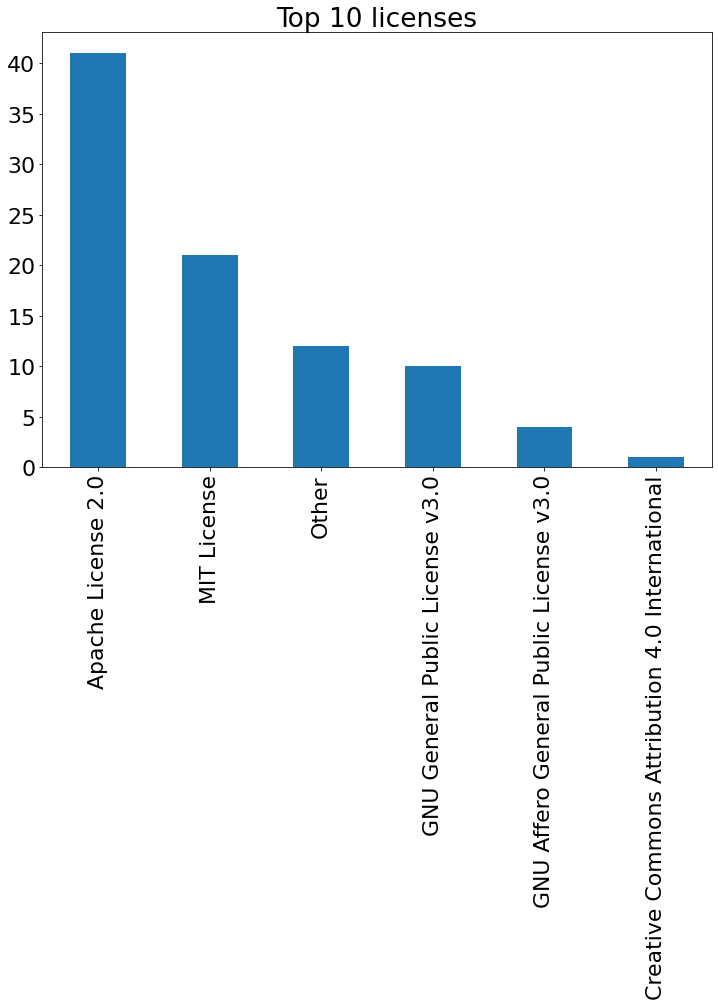

In [68]:
# first 10 licences
repos["license"].value_counts().head(10).plot(kind='bar', title='Top 10 licenses')
plt.savefig(Path(fp_figs, f'licenses_first10_{subset}.png'), bbox_inches="tight")

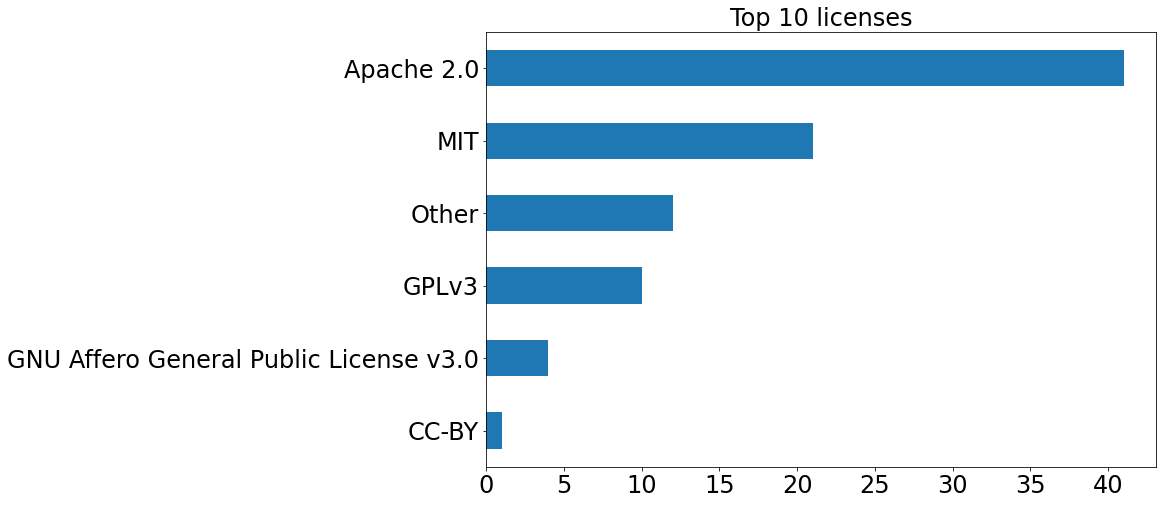

In [69]:
# first 10 licences with short names
ax = repos["license"].replace(licenses_abbr).value_counts().head(10).plot(kind='barh', title='Top 10 licenses')

plt.gca().invert_yaxis()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)
plt.savefig(Path(fp_figs, f'licenses_short_first10_{subset}.png'), bbox_inches="tight")

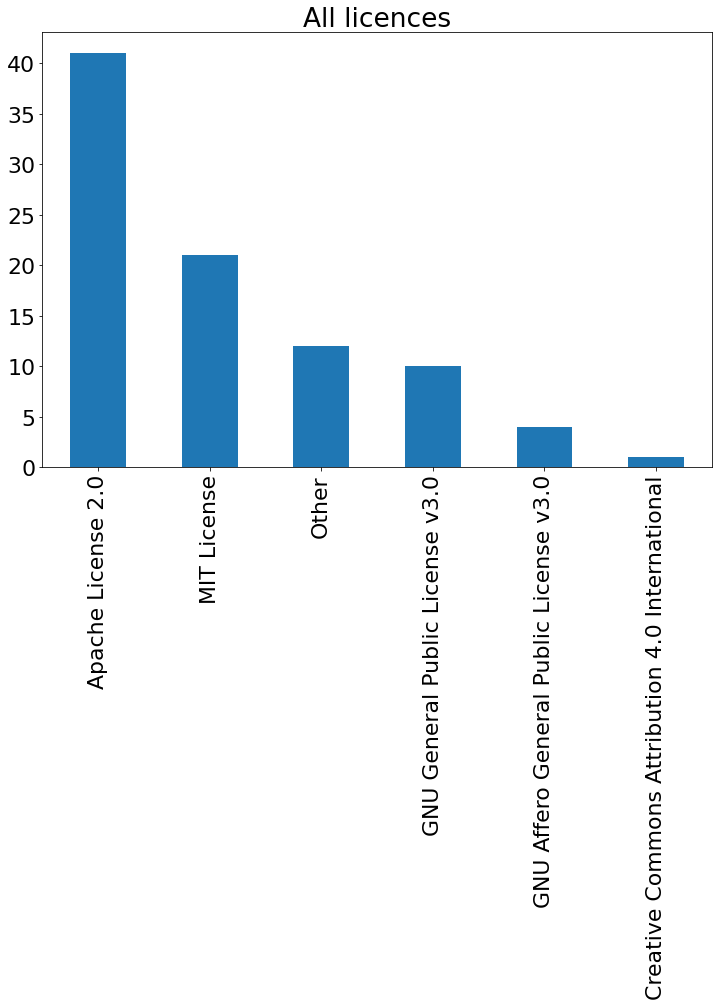

In [70]:
# all licences
repos["license"].value_counts().plot(kind='bar', title = 'All licences')
plt.savefig(Path(fp_figs, f'licenses_all_{subset}.png'), bbox_inches="tight")

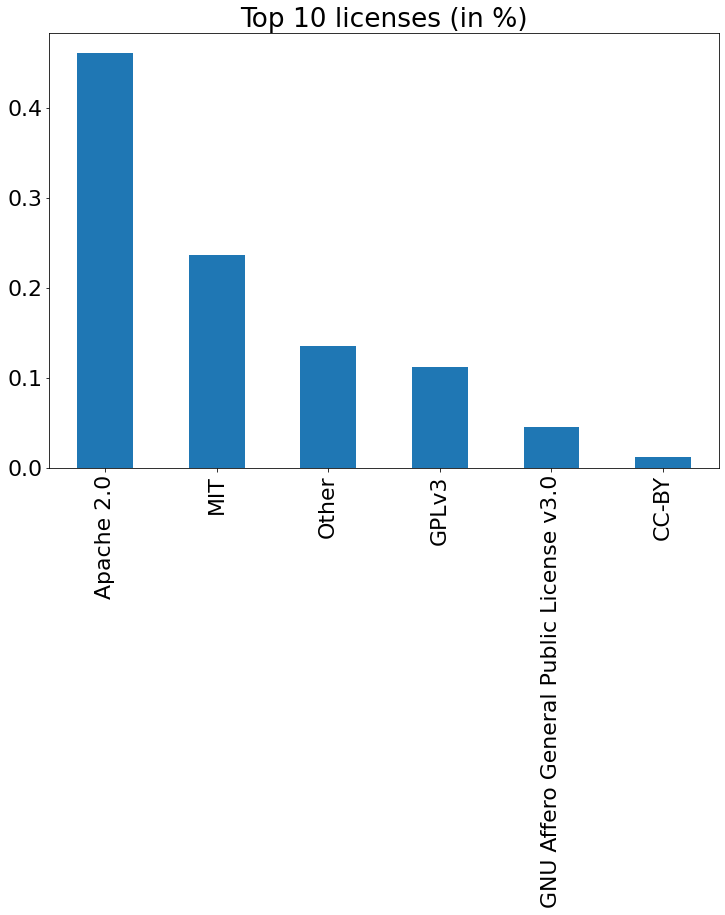

In [71]:
# first 10 licences with short names
repo_licenses_rel = repos["license"].replace(licenses_abbr).value_counts().head(10) / repos["license"].notnull().sum()
repo_licenses_rel.plot.bar(
    title='Top 10 licenses (in %)'
)
plt.savefig(Path(fp_figs, f'licenses_short_first10_percentage_{subset}.png'), bbox_inches="tight")

Below, the propotion of licenses compared to the total is shown, with their absolute count shown below that. . 

In [72]:
percentage_license = int(repos["license"].isna().sum()/len(repos)* 100)
print("{} % of repositories have a license on their page".format(percentage_license))

34 % of repositories have a license on their page


## Languages

The programming language that is used in the repository gives information on the type of project the repository is. data analysis is mostly done in R and Python, though Python is used for other purposes as well. 

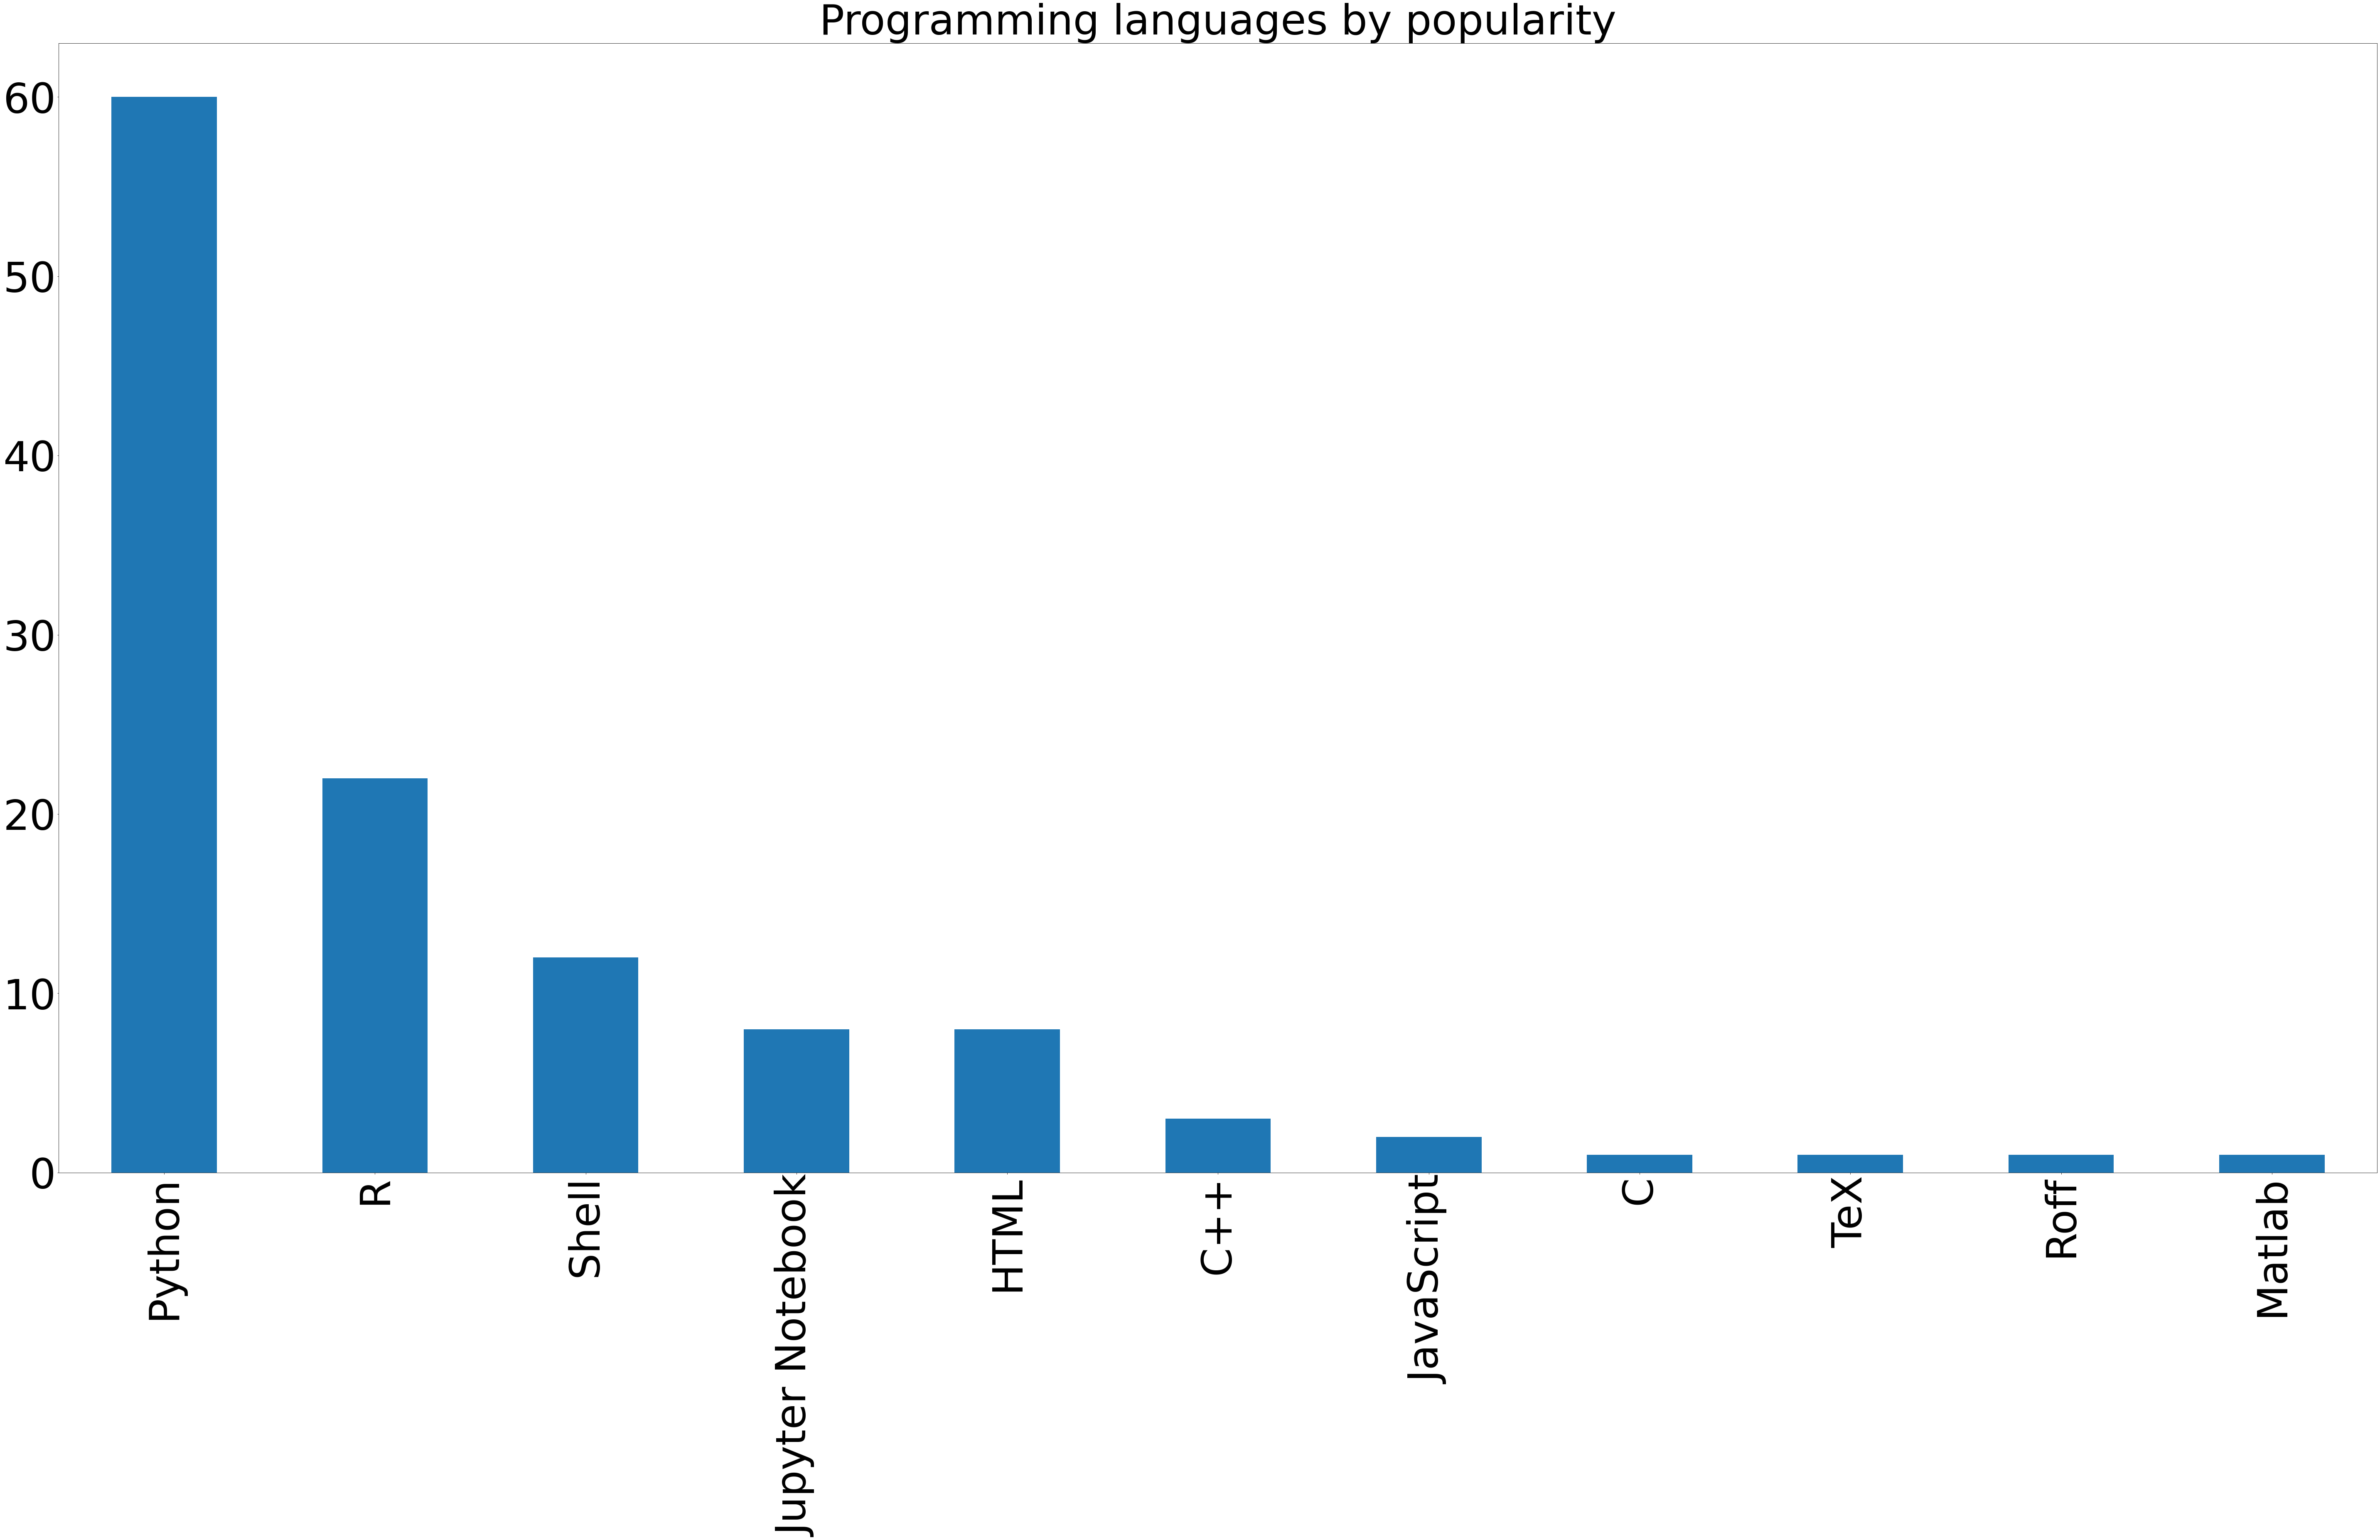

In [73]:
repos["language"].value_counts().plot.bar(figsize = (100,50), fontsize = 100)
plt.title("Programming languages by popularity", fontsize = 100)
plt.savefig(Path(fp_figs, f'language_{subset}.png'), bbox_inches="tight")

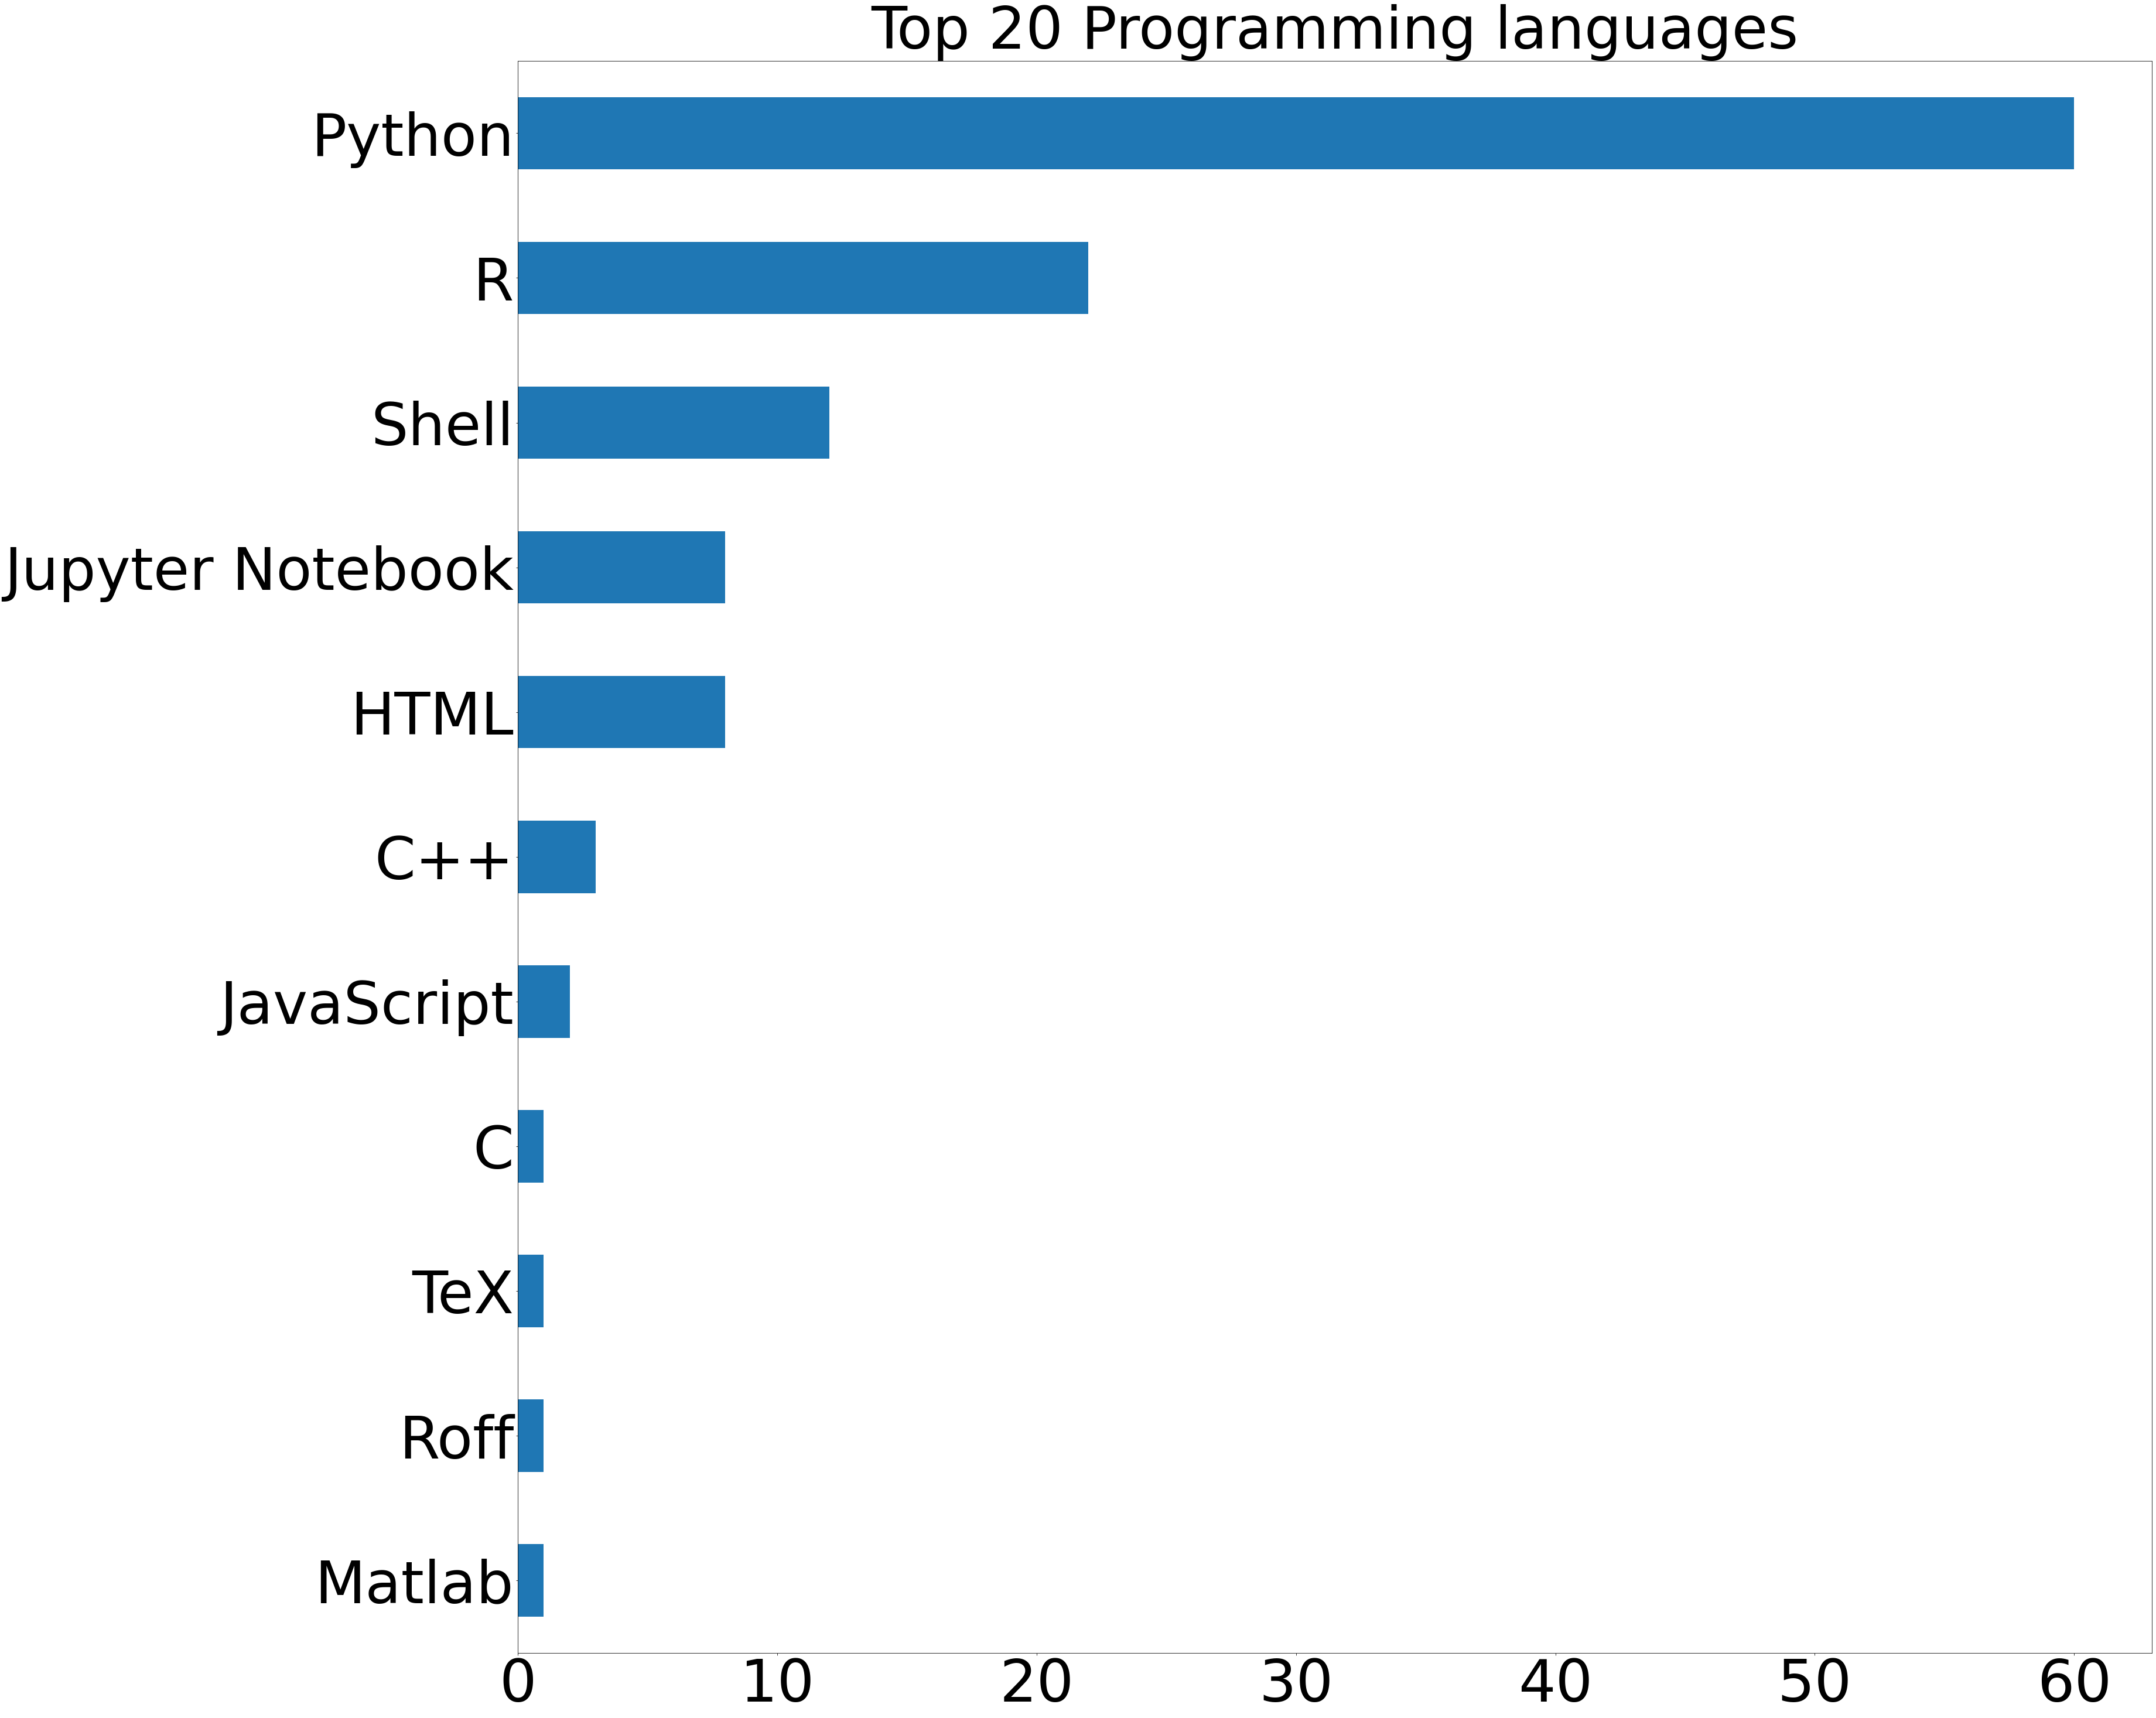

In [74]:
repos["language"].value_counts().head(20).plot.barh(figsize = (50,50), fontsize = 100)
plt.title("Top 20 Programming languages", fontsize = 100)
plt.gca().invert_yaxis()
plt.savefig(Path(fp_figs, f'language_top20_{subset}.png'), bbox_inches="tight")

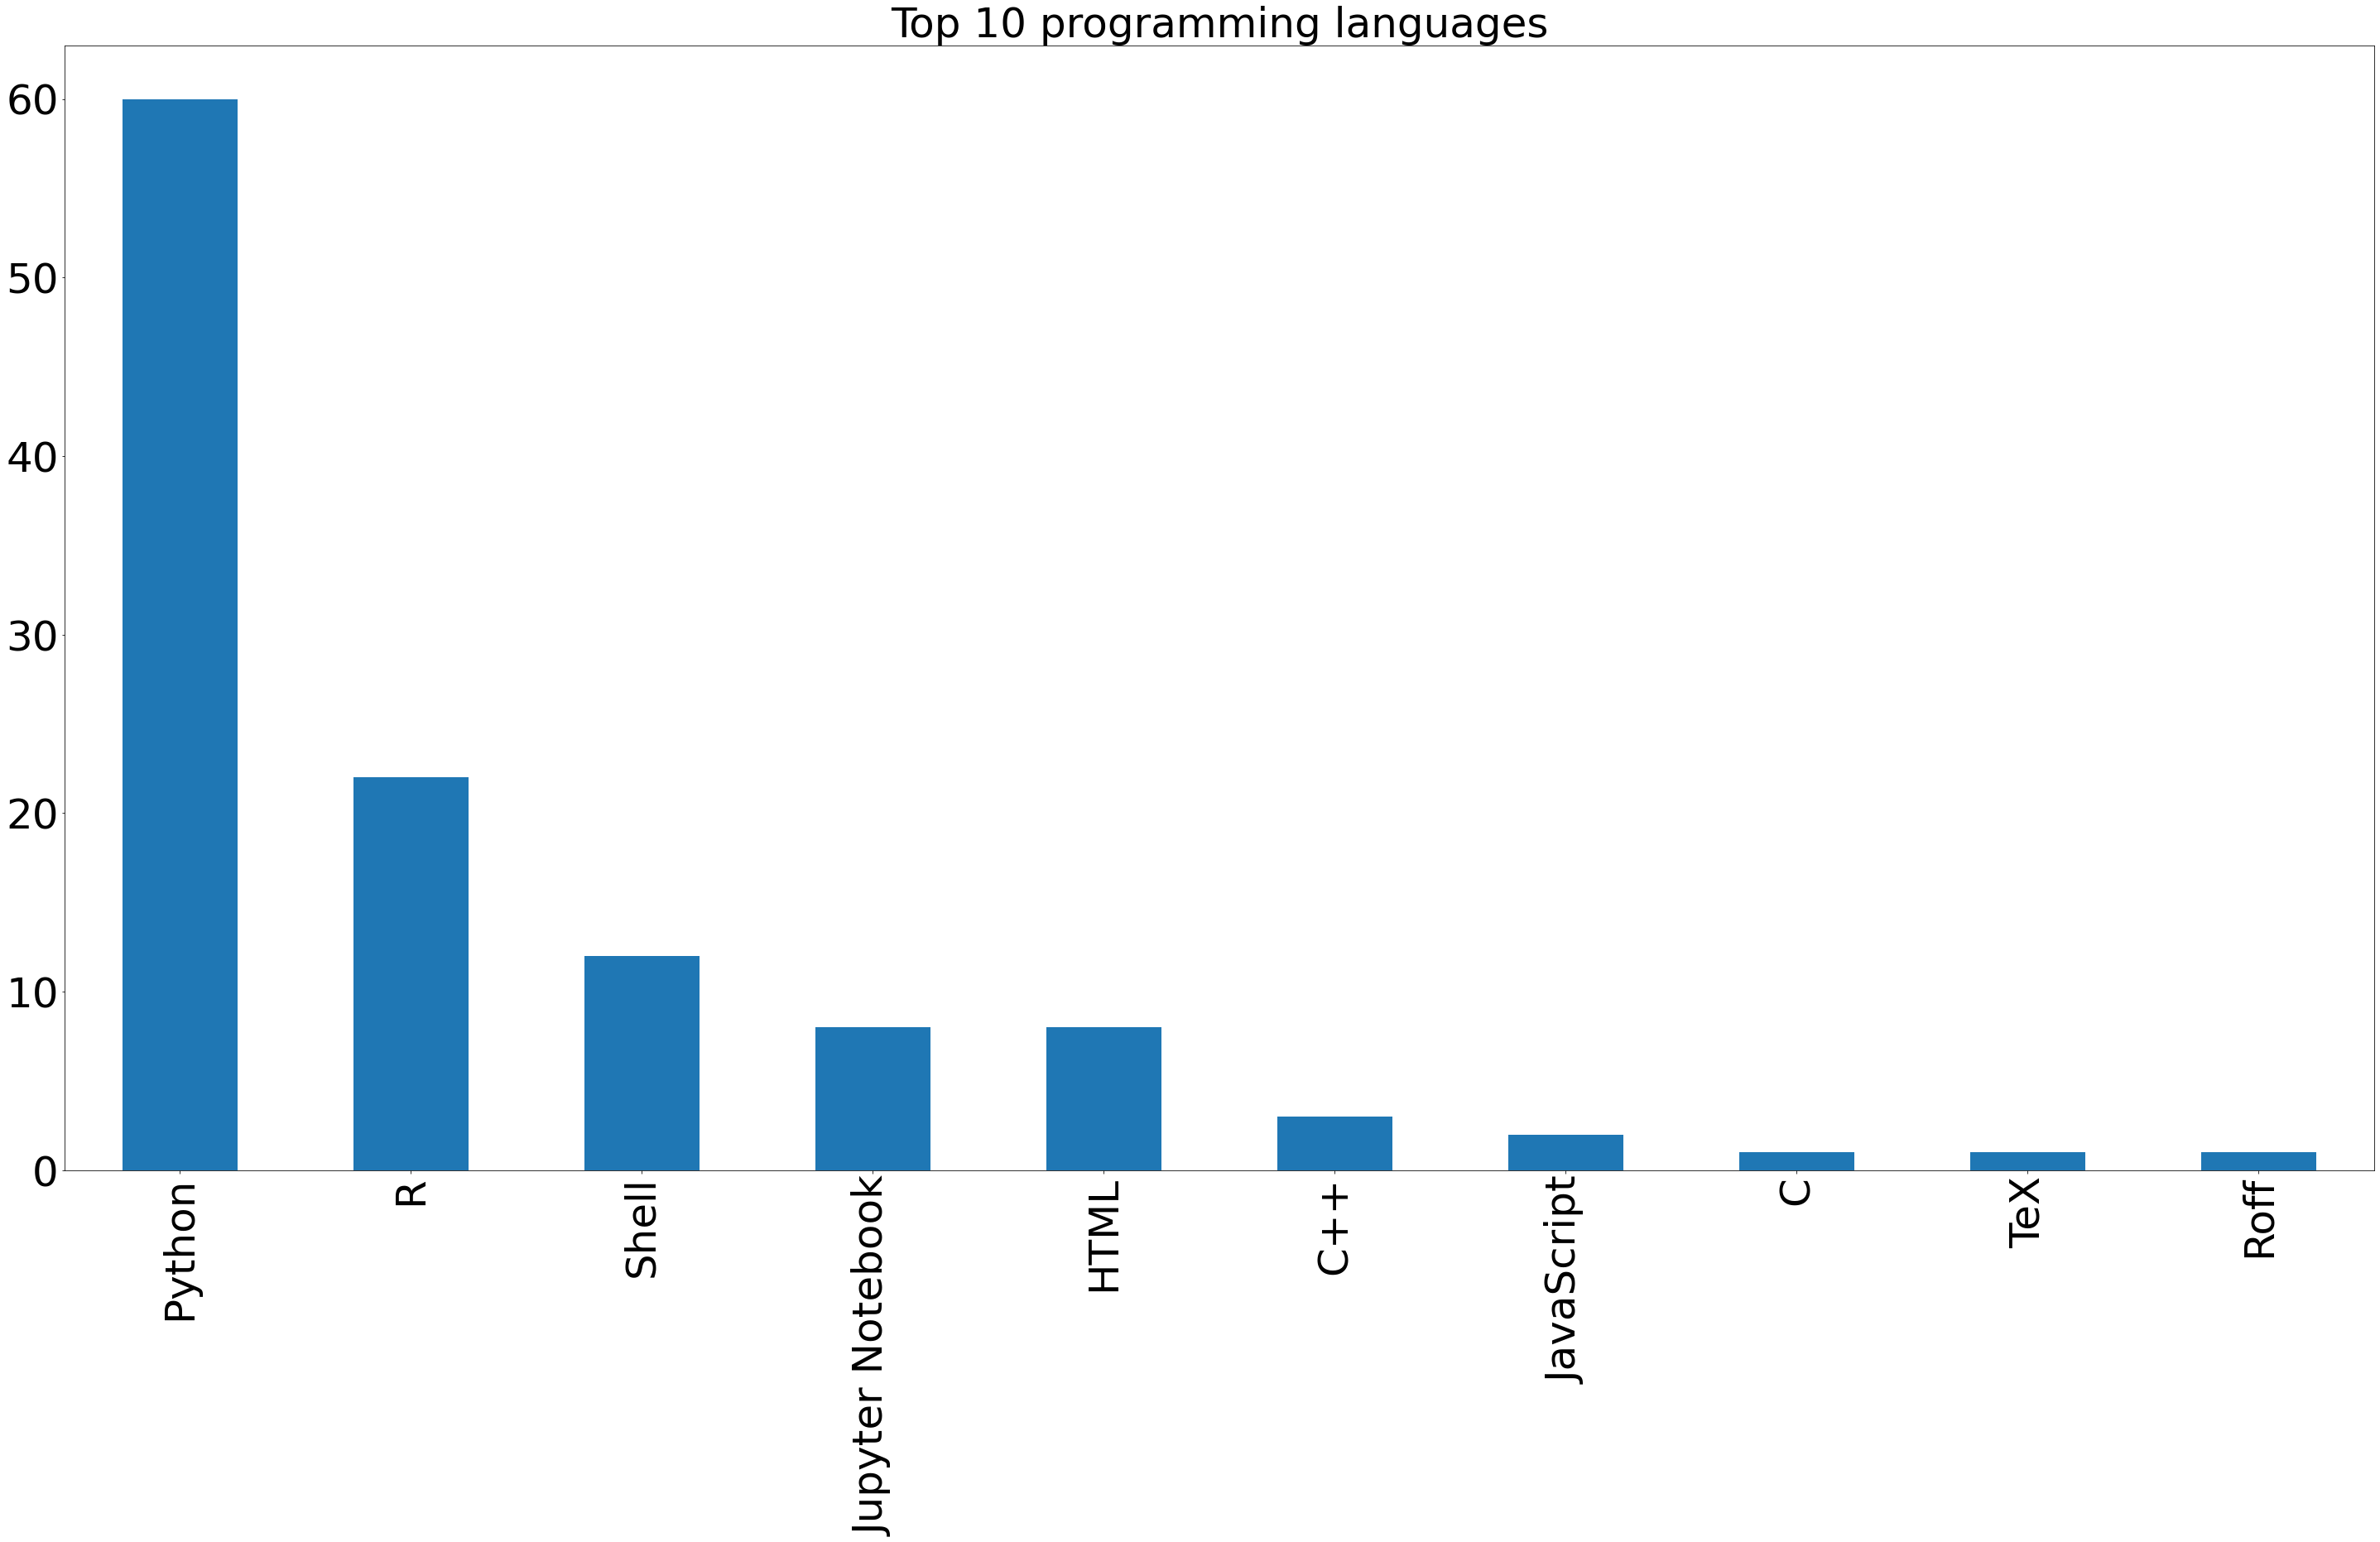

In [75]:
repos["language"].value_counts().head(10).plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 programming languages", fontsize = 50)
plt.savefig(Path(fp_figs, f'language_top10_{subset}.png'), bbox_inches="tight")

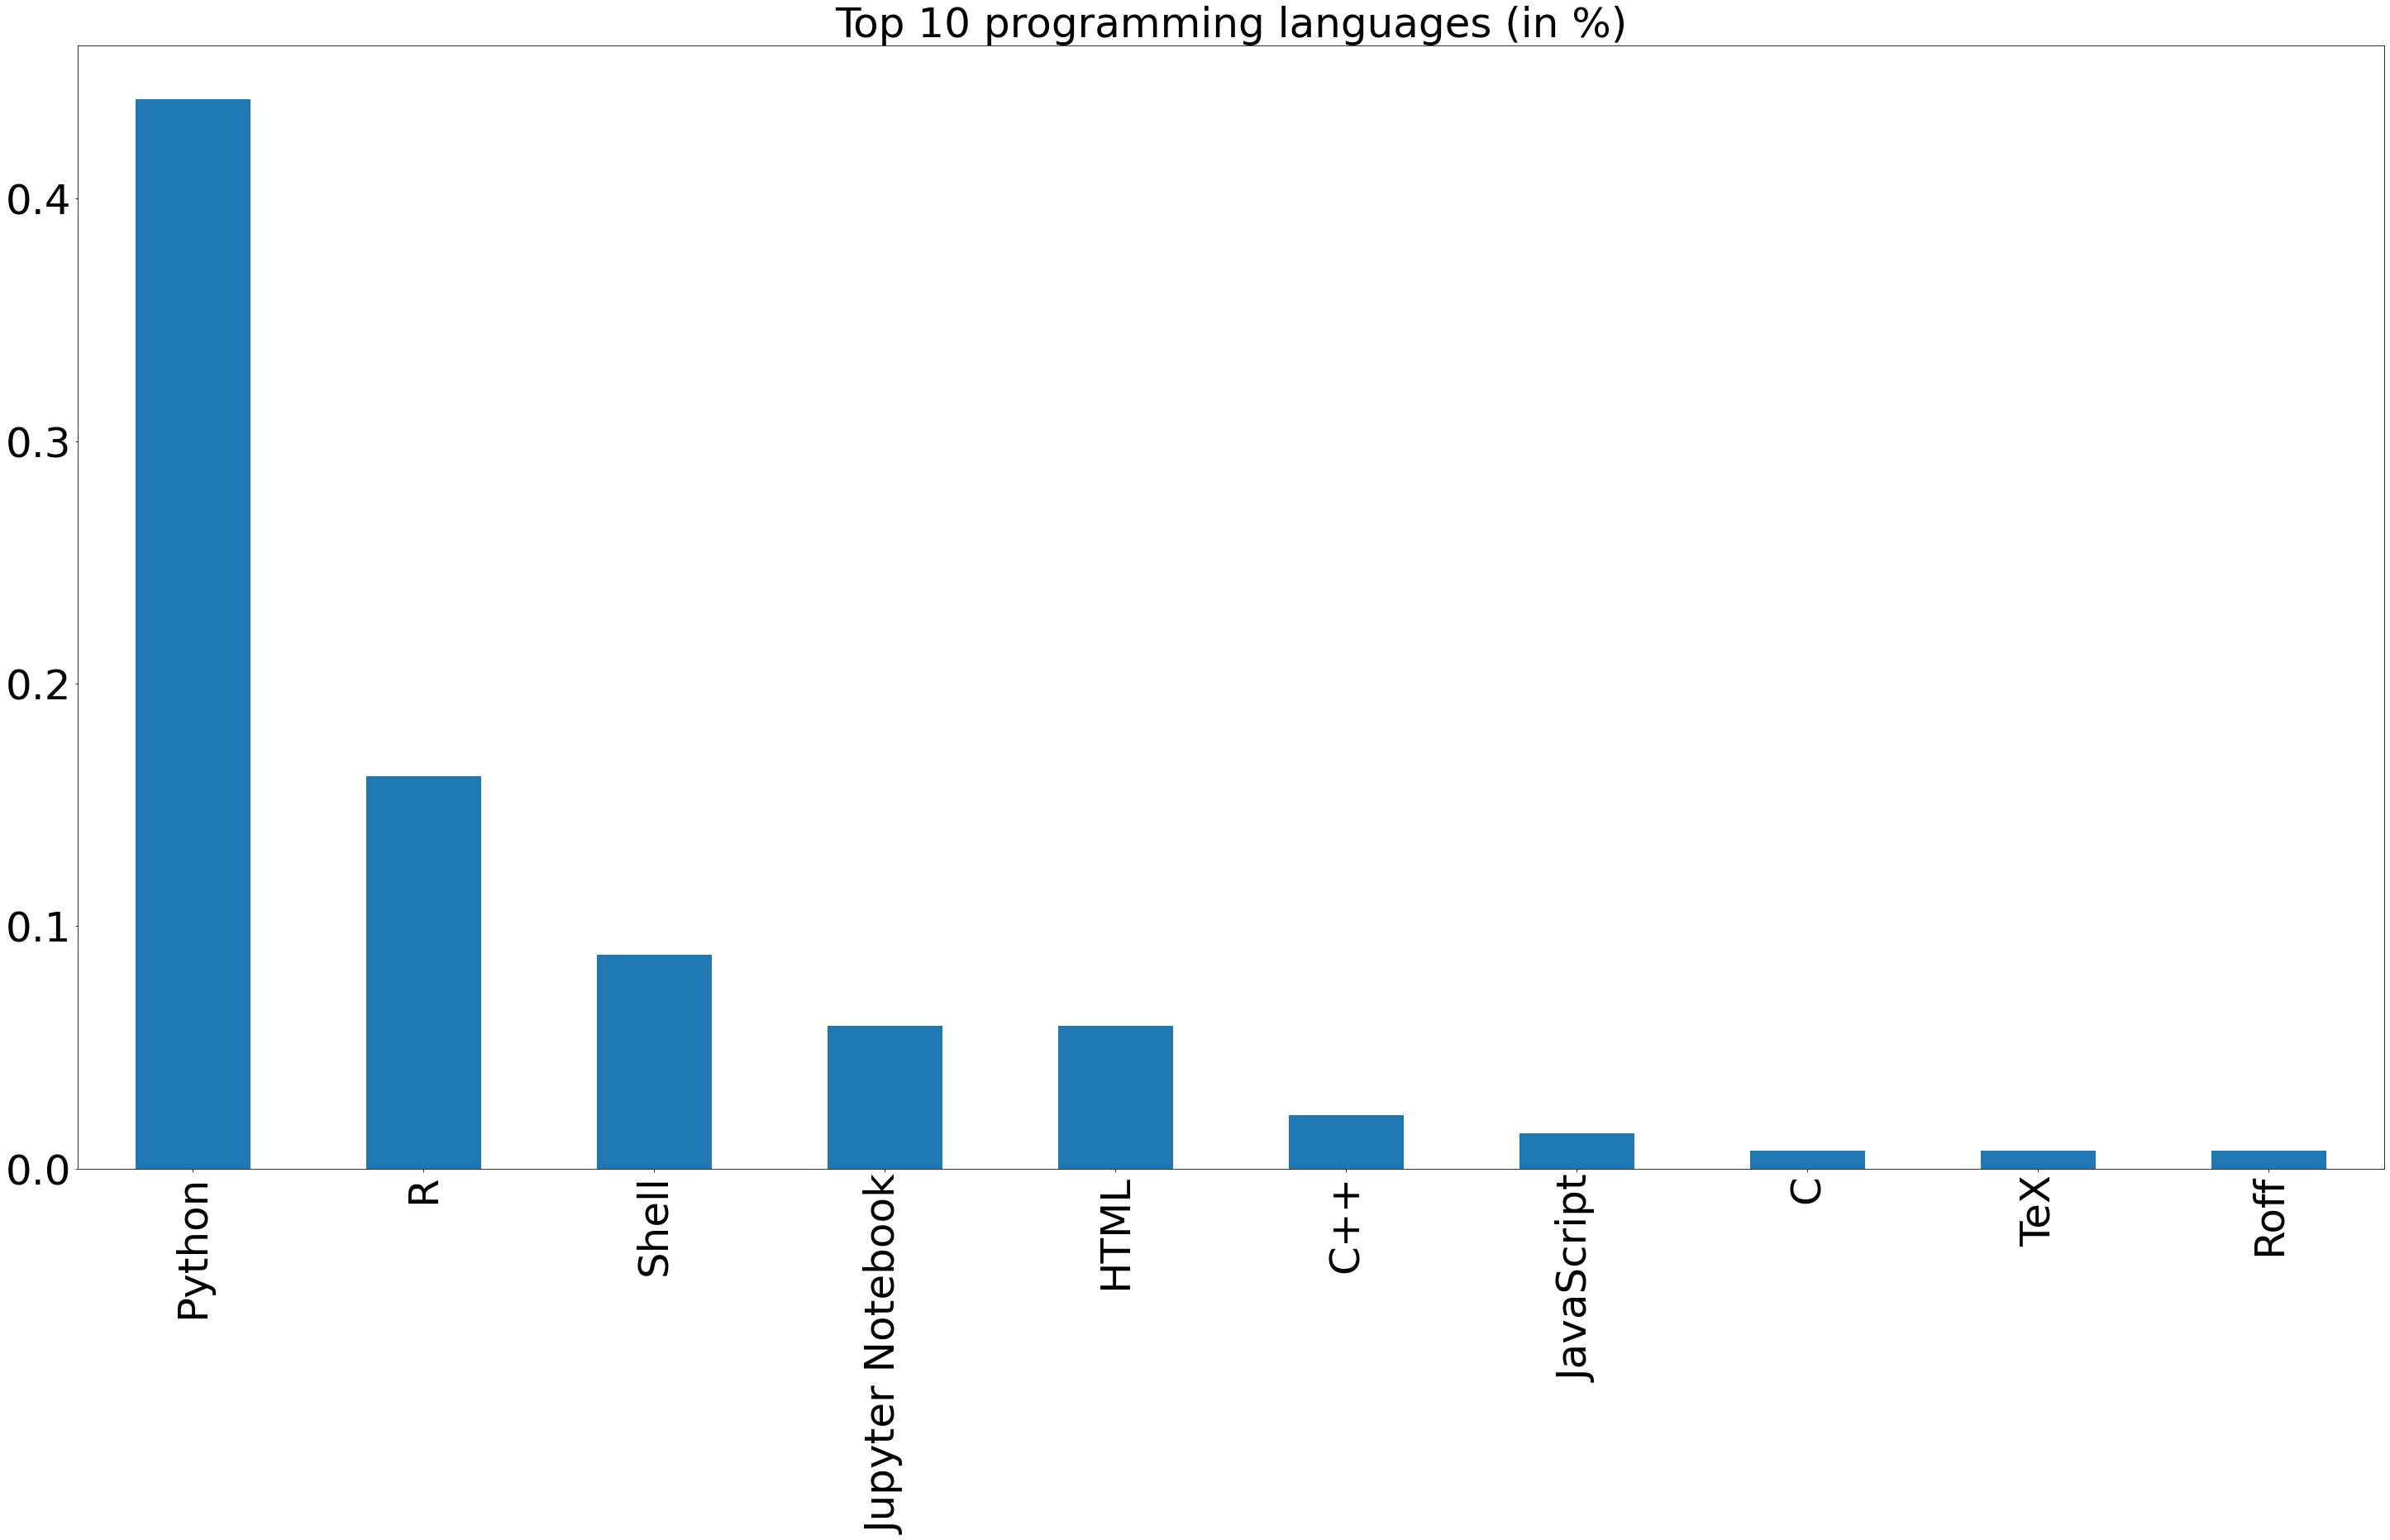

In [76]:
repo_languages_rel = repos["language"].value_counts().head(10) / len(repos)
repo_languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'language_top10_percentage_{subset}.png'), bbox_inches="tight")


## Relative occurence languages

In [77]:
repo_languages_rel

Python              0.441176
R                   0.161765
Shell               0.088235
Jupyter Notebook    0.058824
HTML                0.058824
C++                 0.022059
JavaScript          0.014706
C                   0.007353
TeX                 0.007353
Roff                0.007353
Name: language, dtype: float64

## The following percentages represent the percentage of repositories that contains that specific language for the 10 most occuring languages:

In [78]:
for value, language in zip(languages["language"].value_counts().head(10), languages["language"].value_counts().head(10).keys()):
    percentage = value / len(repos) * 100
    print("{} is present in {:.2f} % of all repositories". format(language, percentage))

Python is present in 60.29 % of all repositories
Shell is present in 36.76 % of all repositories
R is present in 25.74 % of all repositories
HTML is present in 13.24 % of all repositories
C++ is present in 9.56 % of all repositories
Makefile is present in 8.09 % of all repositories
Jupyter Notebook is present in 6.62 % of all repositories
TeX is present in 6.62 % of all repositories
JavaScript is present in 5.88 % of all repositories
C is present in 5.88 % of all repositories


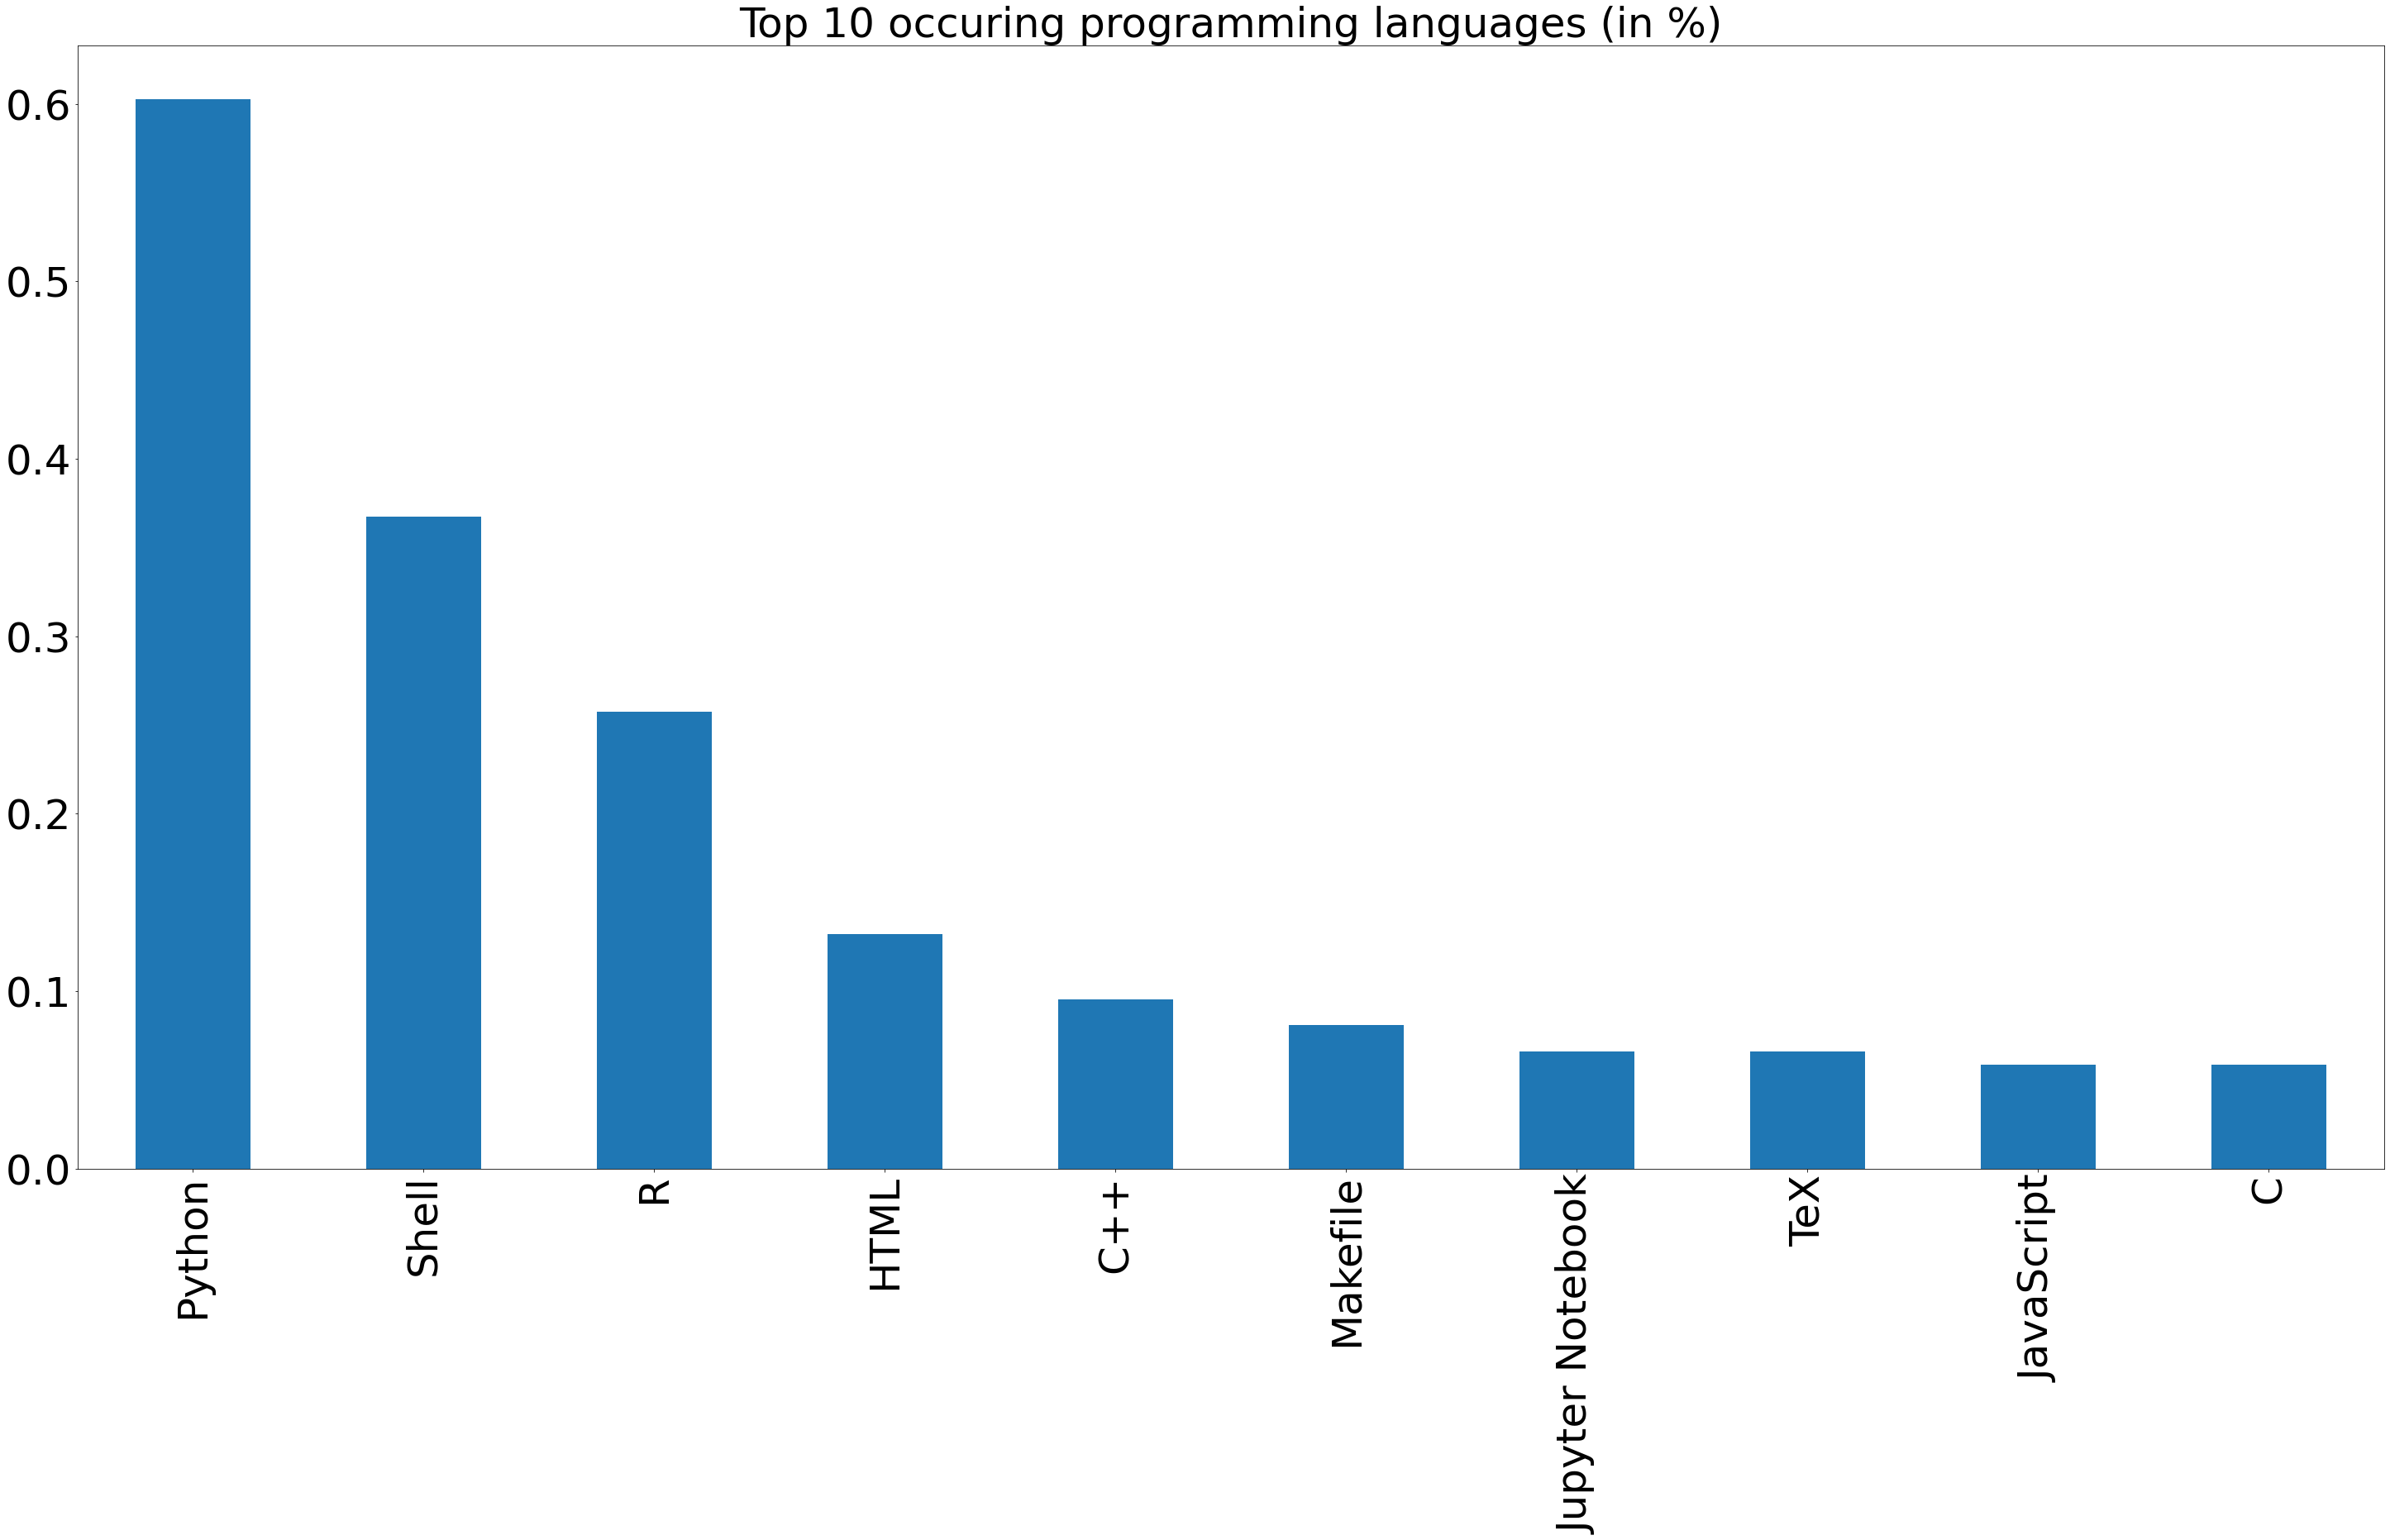

In [79]:
languages_rel = languages["language"].value_counts().head(10) / len(repos)
languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 occuring programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'occurence_language_top10_percentage_{subset}.png'), bbox_inches="tight")


## Correlation table top 10 languages

In [80]:
# languages["language"].value_counts().head(10).keys()
# dict_languages_user = Counter()
# for language in languages["language"].value_counts().head(10).keys():
#     dict_top_languages[language] = 0

In [81]:
# dict_users = {}

In [82]:

# for html_url in repos['html_url']: 
#     #print(html_url)
#     rows_language_for_one_user = languages.loc[languages['html_url_repository'] == html_url]
#     dict_languages_user = Counter()
#     for language in languages["language"].value_counts().head(10).keys(): #set all values of languages that need to be present to create a dataset in a later stage to zero
#         dict_languages_user[language] = 0
#     for language in rows_language_for_one_user['language']:
#         if language in dict_languages_user: #only count languages in the top 10
#             dict_languages_user[language] += 1
#     dict_users[html_url] = dict_languages_user #each user has a dict with 10 booleans representing whether the top 10 language is present in their repo or not


In [83]:
# languages_per_repo = pd.DataFrame.from_dict(dict_users, orient = 'index')

In [84]:
# languages_per_repo.corr().round(decimals = 2)

## Topics

Topics describe the context of the repository. 

In [85]:
topics['topic'].value_counts().nlargest(50)

asreview                         19
james-server                     10
utrecht-university               10
growth-curves                     9
systematic-reviews                8
growth-charts                     6
python                            5
systematic-literature-reviews     5
anthropometry                     4
simulation                        3
dutch                             3
research                          3
active-learning                   3
imputation                        3
chained-equations                 3
mice                              3
restful-api                       2
learning-algorithms               2
geospatial                        2
deep-learning                     2
plugin                            2
netherlands                       2
systematic-reviews-datasets       2
feature-extraction                2
datashield                        2
covid-19                          2
growth-standards                  2
odissei                     

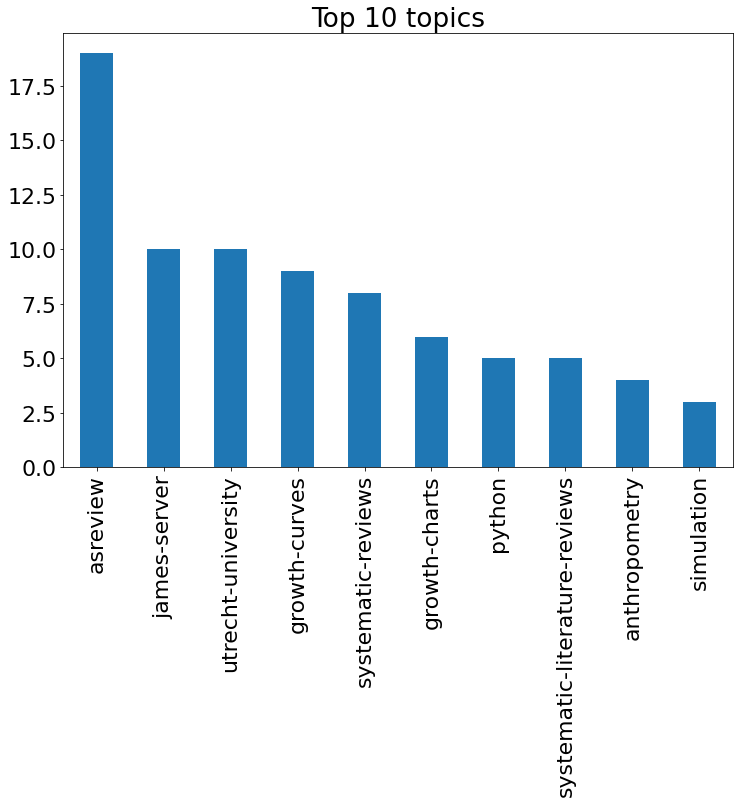

In [86]:
topics['topic'].value_counts().nlargest(10).plot(kind = 'bar', title = 'Top 10 topics')
plt.savefig(Path(fp_figs, f'most_occuring_topics_top10_{subset}.png'), bbox_inches="tight")


## Number of  contributors

The number of contributors gives information on how many people put effort into the repository. Theoratically, it would make sense if a higher amount of contributors implied a more FAIR repository, because those are easier to find in a registery and work on because of their license. 


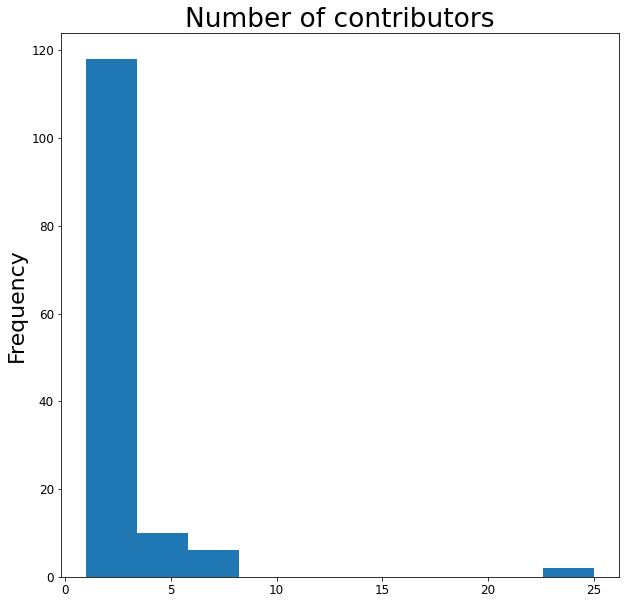

In [87]:
contributors['html_url_repository'].value_counts().plot.hist(x = 'contributors', figsize = (10,10), fontsize = 12, title = 'Number of contributors')
plt.savefig(Path(fp_figs, f'contributors_{subset}.png'), bbox_inches="tight")


In [88]:
contributors['html_url_repository'].value_counts().nlargest(20, keep = 'all')


https://github.com/amices/mice                                         25
https://github.com/asreview/asreview                                   24
https://github.com/haddocking/haddock-tools                             8
https://github.com/asreview/systematic-review-datasets                  7
https://github.com/haddocking/prodigy                                   6
https://github.com/haddocking/pdb-tools                                 6
https://github.com/haddocking/powerfit                                  6
https://github.com/asreview/asreview-covid19                            6
https://github.com/haddocking/prodigy-cryst                             5
https://github.com/sodascience/awesome-citizen-science-nl               5
https://github.com/haddocking/whiscy                                    5
https://github.com/haddocking/disvis                                    5
https://github.com/asreview/asreview-artwork                            5
https://github.com/haddocking/haddock3

In [89]:
print('mean contributors: {:.2f}'.format(statistics.mean(contributors['html_url_repository'].value_counts())))
print('median contributors: {}'.format(statistics.median(contributors['html_url_repository'].value_counts())))

mean contributors: 2.38
median contributors: 2.0


## Howfairis sum score descriptives and correlations

In this section, the median and meand of the howfairis sum score is shown, as well as correlations the how fair is sum score, the amount of contributors and the amount of months since the last commit

In [90]:
how_fair_sum_scores = []
for index, row in how_fair_is.iterrows():
    how_fair_is_sum = row['howfairis_repository'] + row['howfairis_license'] +row['howfairis_registry'] + row['howfairis_citation'] + row['howfairis_checklist']
    how_fair_sum_scores.append(how_fair_is_sum)

mean: 1.86
median: 2.0


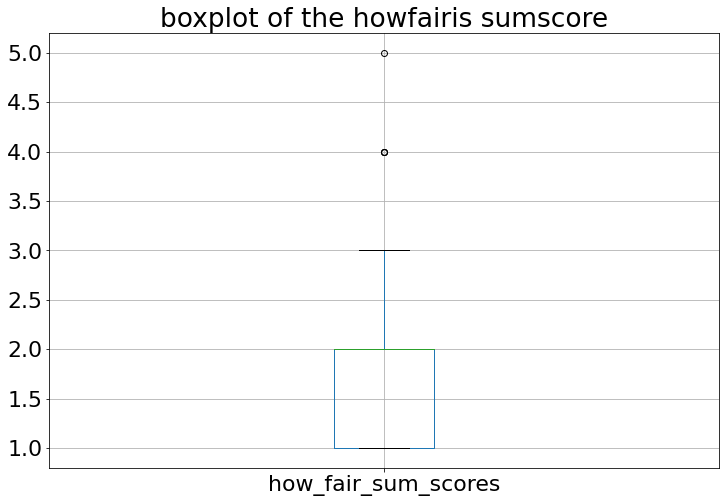

In [91]:
how_fair_is['how_fair_sum_scores'] = how_fair_sum_scores
print("mean: {:.2f}".format(statistics.mean(how_fair_sum_scores)))
print("median: {}".format(statistics.median(how_fair_sum_scores)))
pd.DataFrame((statistics.mean(how_fair_sum_scores), statistics.median(how_fair_sum_scores)),["mean", "median"])
how_fair_is.boxplot(column = 'how_fair_sum_scores')
plt.title('boxplot of the howfairis sumscore')
plt.savefig(Path(fp_figs, f'howfairissum_boxplot_{subset}.png'), bbox_inches="tight")


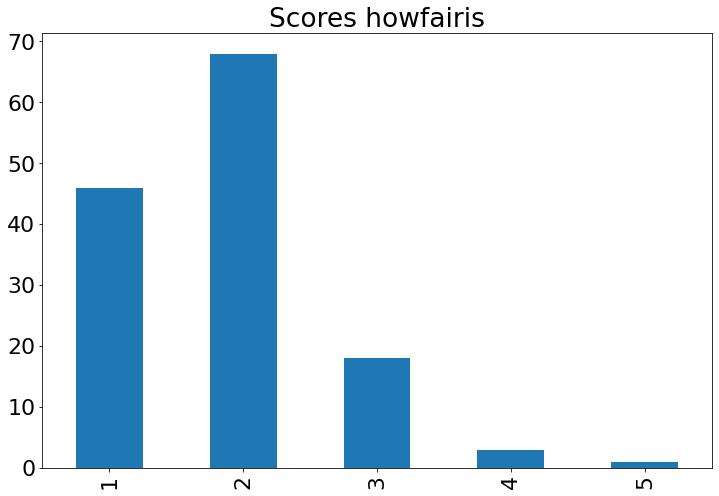

In [92]:
how_fair_is['how_fair_sum_scores'].value_counts().sort_index().plot.bar(title = 'Scores howfairis')
plt.savefig(Path(fp_figs, f'howfairissum_histogram_{subset}.png'), bbox_inches="tight")

In [93]:
# correlation_df = pd.DataFrame()

In [94]:
# correlation_df['how_fair_sum_scores'] = how_fair_sum_scores
# correlation_df['contributions']= contributors['contributions']
# correlation_df['months_ago_most_recent_commit'] = repos['months_ago_most_recent_commit']

In [95]:
# correlation_df.corr(method='pearson').round(decimals=2)

## Binary correlation plot between howfairis variables

A correlation table that shows the correlation between the howfairis measures.

In [96]:
correlation_how_fair_is = pd.DataFrame()

#correlation_how_fair_is['howfairis_repository'] = how_fair_is['howfairis_repository']
correlation_how_fair_is['howfairis_license'] = how_fair_is['howfairis_license']
correlation_how_fair_is['howfairis_registry'] = how_fair_is['howfairis_registry']
correlation_how_fair_is['howfairis_citation'] = how_fair_is['howfairis_citation']
correlation_how_fair_is['howfairis_checklist'] = how_fair_is['howfairis_checklist']



In [97]:
correlation_how_fair_is.corr(method='pearson').round(decimals=2) #howfairis_repository is all true, so has no variance

""


## Programming language and Howfairis

Different programming languages need different licences. For some languages (e.g. python), these are more complex. How does this influence the HowFairis score?

In [98]:
# index_how_fair_is = 0
# language_how_fair_is_df = []
# #get a list with the how-fair-is scores added to the language dataset
# for index,row in languages.iterrows():
#     if how_fair_is['html_url'][index_how_fair_is] != languages['html_url_repository'][index]:
#         index_how_fair_is += 1 
#     sum_score = how_fair_is['how_fair_sum_scores'][index_how_fair_is]
#     language_how_fair_is_df.append(sum_score)
# regression_data_how_fair_is_language = pd.DataFrame()
# language_data_dummies = pd.get_dummies(languages['language'])  #one hot-encoding for language dataset
# regression_data_how_fair_is_language['how_fair_is_sum'] = language_how_fair_is_df
# languages['how_fair_sum_scores'] = regression_data_how_fair_is_language #add scores to language dataset

In [99]:
# train_size = int(len(languages) * 0.8) #training size is 2227, testing size is  557
# regression_how_fair_is_language_train_X = language_data_dummies[:train_size]
# regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
# regression_how_fair_is_language_test_X = language_data_dummies[train_size:]
# regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

In [100]:
# #train regression
# regression_language_how_fair_is = LinearRegression()
# regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# # Make predictions using the testing set
# language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# # The coefficients
# #print('Coefficients: \n', regression_language_how_fair_is.coef_)

# # The mean squared error
# print('Mean squared error: %.2f'
#       % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f'
#       % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


In [101]:
# language_subset = language_data_dummies[['Python', 'Shell', 'R', 'JavaScript', 'HTML']] #top 5 languages


In [102]:
# train_size = int(len(language_subset) * 0.8)
# regression_how_fair_is_language_train_X = language_subset[:train_size]
# regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
# regression_how_fair_is_language_test_X = language_subset[train_size:]
# regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

In [103]:
# #train regression
# regression_language_how_fair_is = LinearRegression()
# regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# # Make predictions using the testing set
# language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# # The coefficients
# print('Coefficients: \n', regression_language_how_fair_is.coef_)

# # The mean squared error
# print('Mean squared error: %.2f'
#       % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f'
#       % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


A simple regression for predicting the how fair is score from  all or a subset of languages does not seem to yield any results 

## Examples of high howfairis scores 

In this section, some links to the pages that have a high howfairis score are shown. 

In [104]:
how_fair_is_high_scores = how_fair_is[how_fair_is['how_fair_sum_scores'] > 3].sort_values('how_fair_sum_scores', ascending=False)

how_fair_is_high_scores[['html_url', 'how_fair_sum_scores']]

,html_url,how_fair_sum_scores
1104,https://github.com/puregome/notebooks,5
88,https://github.com/asreview/asreview,4
430,https://github.com/computationalgeography/lue,4
681,https://github.com/haddocking/pdb-tools,4


## Re-use of other projects and articles

Are there competitors?
How do they relate to each other?